## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os
from itertools import islice

import sinogap_module_exp as sg



### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**6
    ,batchSplit = 2**3
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3

    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(8,False)


#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, expose = 1e-2)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: 

### <font style="color:lightblue">Show</font>

In [5]:
#st=0.6
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 336, 645), 0.725),
    #((0, 298, 1557), 0.846),
    ((3, 925,  592), 0.35)
    #(0, 0, 360, 2108)
    #(0, 0, 338, 773)
    #(0, 0, 411, 1169)
]
#sg.generator.eval()
#print(st)
sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.displayImages()
#st += 0.01
#rindex = sg.showMe(sg.testSet)
#img, ridx = sg.testSet[rindex]
#print(ridx, rindex)
#sg.displayImages(img.to(sg.TCfg.device))


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:
def unrollArch2(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator2(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 8.799e-03
    # 'MSEN'   : 5.276e+00
    # 'L1L'    : 1.290e-01
    # 'L1LN'   : 7.558e+00
    # 'SSIM'   : 4.114e-04
    # 'MSSSIM' : 3.784e-06
    def __init__(self):
        super(DBricksGenerator2, self).__init__(2, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 64
        unrollArch2(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks2.pt" )


class StripeGenerator2(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator2, self).__init__(2, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch2(self)


class Generator2(sg.GeneratorTemplate) :
    # 'Adv'    : 0.0000+00   :
    # 'MSE'    : 9.966e-02   :   .2976
    # 'MSEN'   : 1.434e+01   :   .3517
    # 'L1L'    : 3.407e+00   :   .6491
    # 'L1LN'   : 4.572e+01   :   .6081
    # 'SSIM'   : 2.689e-04   :   .4003
    # 'MSSSIM' : 3.695e-06   :   .4075
    def __init__(self):
        super(Generator2, self).__init__(2, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator2()
        self.stripeGenerator = StripeGenerator2()
        self.baseChannels = 4
        unrollArch2(self)
        #sg.load_model(self, model_path="saves/aio/models/full2.pt" )





### Generator 4pix

In [7]:
def unrollArch4(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator4(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 1.523e-02
    # 'MSEN'   : 2.273e+01
    # 'L1L'    : 5.012e-01
    # 'L1LN'   : 3.372e+01
    # 'SSIM'   : 5.145e-04
    # 'MSSSIM' : 4.068e-06
    def __init__(self):
        super(DBricksGenerator4, self).__init__(4, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator2()
        #self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 64
        unrollArch4(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks4.pt" )


class StripeGenerator4(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator4, self).__init__(4, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch4(self)


class Generator4(sg.GeneratorTemplate) :
    # 'Adv'    : 0.0000+00   :
    # 'MSE'    : 4.597e-01   :   .5819
    # 'MSEN'   : 6.000e+01   :   .5839
    # 'L1L'    : 1.777e+01   :   .7987
    # 'L1LN'   : 2.033e+02   :   .7831
    # 'SSIM'   : 3.888e-04   :   .7386
    # 'MSSSIM' : 3.565e-06   :   .7840
    def __init__(self):
        super(Generator4, self).__init__(4, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator4()
        self.brickGenerator.lowResGenerator = None
        self.stripeGenerator = StripeGenerator4()
        self.lowResGenerator = Generator2()
        self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 4
        unrollArch4(self)
        #sg.load_model(self, model_path="saves/aio/gap4_full_tmp/model_gen.pt" )


### Generator 8pix

In [8]:
def unrollArch8(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        gen.encblock( 16,16, 3),
        gen.encblock( 16,32, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(64,16, 3, stride=2),
        gen.decblock(32,16, 3),
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen




class DBricksGenerator8(sg.SubGeneratorTemplate) :
    # 'Adv'    :  0.000e+00
    # 'MSE'    :  1.057e-01
    # 'MSEN'   :  1.264e+02
    # 'L1L'    :  2.759e+00
    # 'L1LN'   :  1.678e+02
    # 'SSIM'   :  1.338e-03
    # 'MSSSIM' :  7.102e-06
    def __init__(self):
        super(DBricksGenerator8, self).__init__(8, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator4()
        self.baseChannels = 64
        unrollArch8(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks8.pt" )




class StripeGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(StripeGenerator8, self).__init__(8, False, batchNorm=True)
        self.lowResGenerator = None
        self.baseChannels = 2
        unrollArch8(self)


class Generator8(sg.GeneratorTemplate) :
    # 'Adv'    :    :
    # 'MSE'    :    :
    # 'MSEN'   :    :
    # 'L1L'    :    :
    # 'L1LN'   :    :
    # 'SSIM'   :    :
    # 'MSSSIM' :    :
    def __init__(self):
        super(Generator8, self).__init__(8, batchNorm=True, inChannels=4)
        self.brickGenerator = DBricksGenerator8()
        self.brickGenerator.lowResGenerator = None # will use results of self.lowResGenerator instead
        self.stripeGenerator = StripeGenerator8()
        self.lowResGenerator = Generator4()
        self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 4
        unrollArch8(self)
        #sg.load_model(self, model_path="saves/aio/models/full2.pt" )
    #def forward(self, images):
    #    with torch.no_grad():
    #        images, norms = self.normalizeImages(images)
    #    bricksM = self.brickGenerator.forward(images.view(-1,1, *self.brickGenerator.cfg.sinoSh))
    #    bricksM = bricksM.view(-1,1, *self.cfg.sinoSh)
    #    edge = self.brickGenerator.cfg.sinoSh[-2]//2
    #    bricksP = images.clone()
    #    bricksP[:,:,edge:-edge,:] = self.brickGenerator.forward(images[:,:,edge:-edge,:].reshape(-1,1, *self.brickGenerator.cfg.sinoSh)) \
    #        .view(-1,1, self.cfg.sinoSh[-2]-2*edge, self.cfg.sinoSh[-1] )
    #    results = ( bricksM + bricksM ) / 2
    #    return self.reNormalizeImages(results, norms)



generator = Generator8()
#generator.requires_grad_(False)
#def reuseLowResWeights(genP, genL) :
#    nofL = sum(1 for dummy in genL.decoders.parameters())
#    nofP = sum(1 for dummy in genP.decoders.parameters())
#    for trg, src in zip( islice(genP.encoders.parameters(), nofL),
#                         genL.encoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( islice(genP.decoders.parameters(), nofP-nofL, nofP),
#                         genL.decoders.parameters() ) :
#        trg[...] = src[...]
#    for trg, src in zip( genP.lastTouch.parameters(),
#                         genL.lastTouch.parameters() ) :
#        trg[...] = src[...]
#reuseLowResWeights(generator, generator.lowResGenerator)
#reuseLowResWeights(generator.stripeGenerator, generator.lowResGenerator.stripeGenerator)
#sg.save_model(generator, model_path="tmp.pt" )
sg.load_model(generator, model_path="tmp.pt" )

generator.requires_grad_(True)
generator.lowResGenerator.requires_grad_(False)

generator = generator.to(sg.TCfg.device)
sg.generator = generator
#
model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
print(model_summary)
#




Layer (type:depth-idx)                                  Output Shape              Param #
Generator8                                              [1, 1, 2048, 64]          --
├─Generator4: 1-1                                       --                        --
│    └─Generator2: 2-1                                  --                        --
│    │    └─StripeGenerator2: 3-1                       --                        (8,399,630)
│    │    └─DBricksGenerator2: 3-2                      --                        (15,328,707)
│    │    └─ModuleList: 3-3                             --                        (9,236)
│    │    └─Sequential: 3-4                             [1, 32, 64, 2]            (33,562,624)
│    │    └─ModuleList: 3-5                             --                        (18,252)
│    │    └─Sequential: 3-6                             [1, 1, 512, 16]           (9)
│    └─StripeGenerator4: 2-2                            --                        --
│    │    └─ModuleL

### <font style="color:lightblue">Generator</font>

In [11]:
#sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
#model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
#print(sg.refImages.shape, sg.refImages[[0],...].shape)
#print(model_summary)


### <font style="color:lightblue">Discriminator</font>

In [12]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 2.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 2.10


## <font style="color:lightblue">Norms</font>

In [ ]:
#sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=0)
#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


### no prenorm

sg.metrices = {
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 0.000e+00, 0),
    'MSE'    : sg.Metrics(sg.loss_MSE,     3.364e+00, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    3.046e+02, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     1.021e+02, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    1.023e+03, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    1.111e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  3.669e-07, 0),
    'STD'    : sg.Metrics(sg.loss_STD,     9.792e-03, 0),
    'COR'    : sg.Metrics(sg.loss_COR,     4.089e-02, 0),
}


# brick-only estimation
#generator.brickGenerator.lowResGenerator = DBricksGenerator4()
#sg.load_model(generator.brickGenerator.lowResGenerator, model_path="saves/aio/models/dbricks4.pt" )
#generator = generator.to(sg.TCfg.device)
#_ = sg.summarizeMe(sg.testLoader, False)



#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [15]:
#sg.optimizer_G = None
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)

savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
sg.writer.add_graph(sg.generator, ((sg.refImages),) )
#sg.writer.add_graph(sg.discriminator, refImages)

#sg.load_model(sg.generator, model_path="model_1_gen.pt" )
#sg.load_model(sg.generator.brickGenerator, model_path="saves/complex/models/bricks4.pt" )
#sg.load_model(sg.generator.lowResGenerator, model_path="saves/complex/models/stripe2.pt" )
#sg.generator.brickGenerator.lowResGenerator.requires_grad_(False)
#sg.generator.stripeGenerator.lowResGenerator.requires_grad_(False)


#sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)


#sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 0.1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


/home/imbl/usr/src/sinogap/sinogap_module_exp.py:748: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.inChannels > 1 and  images.shape[1] == 1 : # fill missing channels with noise
/home/imbl/usr/venv/torchEnv/lib/python3.13/site-packages/torch/jit/_trace.py:1304: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1120 / 524288 (0.2%)
Greatest absolute difference: 0.0011608600616455078 at index (0, 0, 1881, 4) (up to 1e-05 allowed)
Greatest relative difference: 0.1078537821208831 at index (0, 0, 1495, 28) (up to 1e-05 allowed)
  _check_trace(


Initial LR : G 1.000e-03 (1.0000)


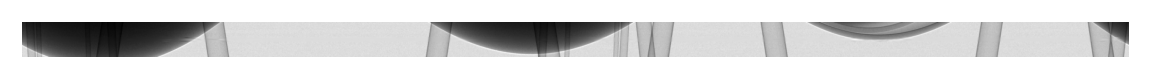

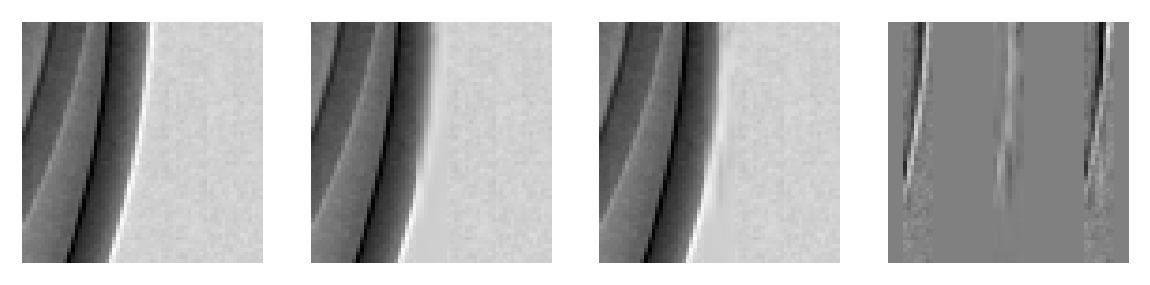

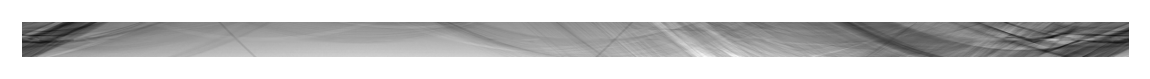

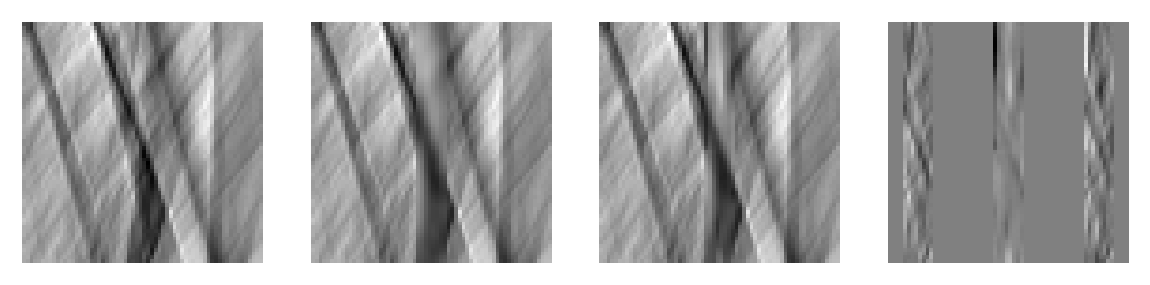

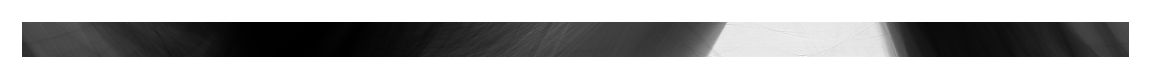

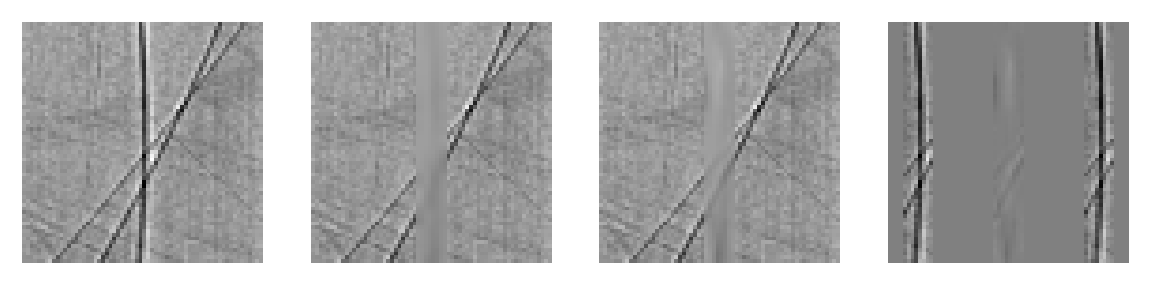

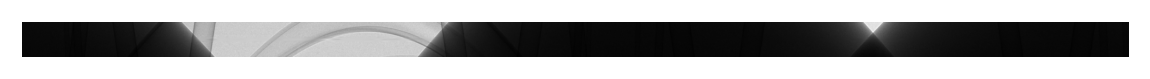

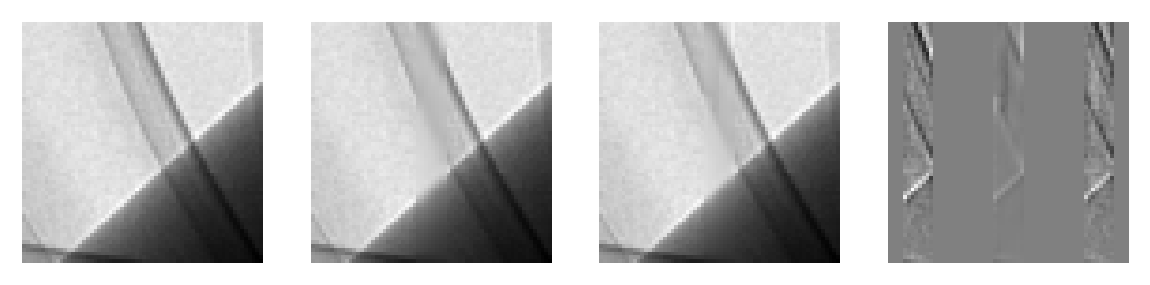

In [16]:
#sg.generator.eval()
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 1 (0).  Images: 384. DIS: 0.000e+00, GEN: 1.565e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 9.000e+01  MSE: 1.565e+00  MSEN: 7.170e+00  L1L: 1.785e+00  L1LN: 3.489e+00  SSIM: 1.828e+00  MSSSIM: 1.828e+00  STD: 1.486e+00  COR: 4.391e+00 



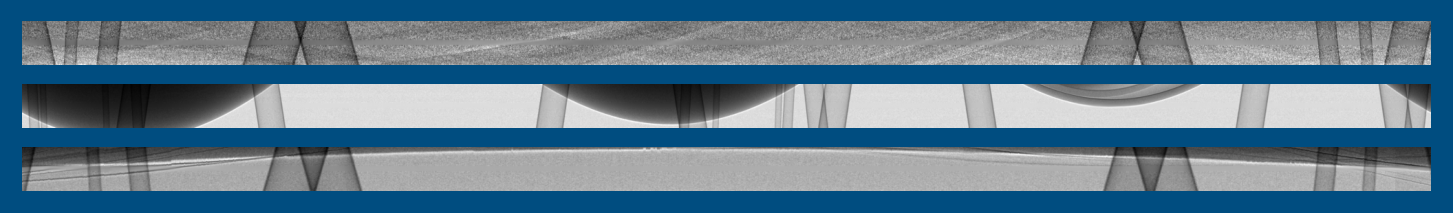

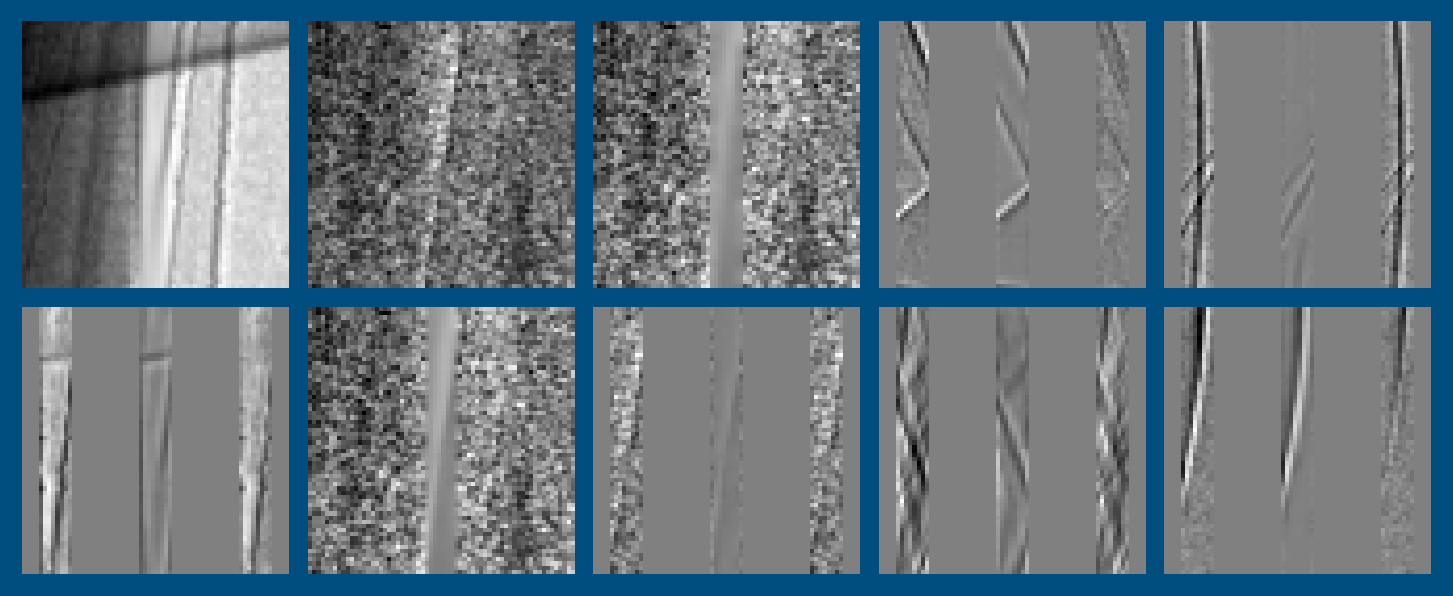

  3%|▎         | 68/2223 [12:31<6:33:07, 10.95s/it]

In [ ]:


sg.scheduler_G.gamma = 1-0.01
def my_beforeReport(sglocals) :
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.0001)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

#minRefDistance = 0.018
def my_afterReport(sglocals) :
    global minRefDistance
    #refDistance = sg.loss_MSE( sglocals['refViews'][[2],[0],...], sglocals['refViews'][[2],[2],...]).sum().cpu().item()
    refDistance = np.std( ( sglocals['refViews'][[2],[0],...] - sglocals['refViews'][[2],[2],...] )[sg.DCfg.gapRng] )
    if refDistance < minRefDistance :
        print(f"New minRefDistance: {refDistance:.6f}, Previous: {minRefDistance:.6f}")
        minRefDistance = refDistance
        sg.saveCheckPoint(savedCheckPoint+"_catchMe.pth",
                       sg.epoch-1, sg.imer, sg.minGEpoch, minRefDistance,
                       sg.generator, sg.discriminator,
                       sg.optimizer_G, sg.optimizer_D)
        sg.tifffile.imwrite(f"catchMeFull_{sg.TCfg.exec}.tif", np.transpose( sglocals['genImages'][2,0,...].cpu().numpy(), (-1,-2)) )
        sg.tifffile.imwrite(f"catchMePatch_{sg.TCfg.exec}.tif", sglocals['refViews'][2,2,...])
    sg.writer.add_scalars("Aux", {'RefDistance' : refDistance}, sg.imer)
    return
#sg.afterReport = my_afterReport



def my_beforeEachEpoch(sglocals) :
    #return
    sg.TCfg.batchSize = min(2**10, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**6))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

#sg.TCfg.num_workers=0
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# bricks pretrained


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.save_model(generator, "dbricks2.pt")